# Hybrid Rocket Motors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import least_squares, root_scalar
from scipy.interpolate import UnivariateSpline

# Module used to parse and work with units
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [2]:
# these lines are only for helping improve the display
#import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['mathtext.fontset'] = 'cm'

## Extracting parameters

:::{figure} ../images/hybrid-rocket-htpb.*
:label: hybrid-regression-data
:alt: Hybrid rocket HTPB/GOX fuel regression rate
:align: center
:width: 500px

Experimental data and fits for HTPB/GOX fuel regression rate as a function of oxidizer mass flux. 
Source: {cite}`sutton2016rocket`.
:::

In [3]:
data = np.genfromtxt('hybrid-htpb-regression.csv', delimiter=',')

In [4]:
def func(param, Go, rdot):
    ''' rdot = a * Go^n
    '''
    return rdot - param[0] * np.power(Go, param[1])

In [5]:
res = least_squares(func, [0.1, 0.5], args=(data[:,0], data[:,1]))
print(res.x)

[0.1058803  0.69835809]


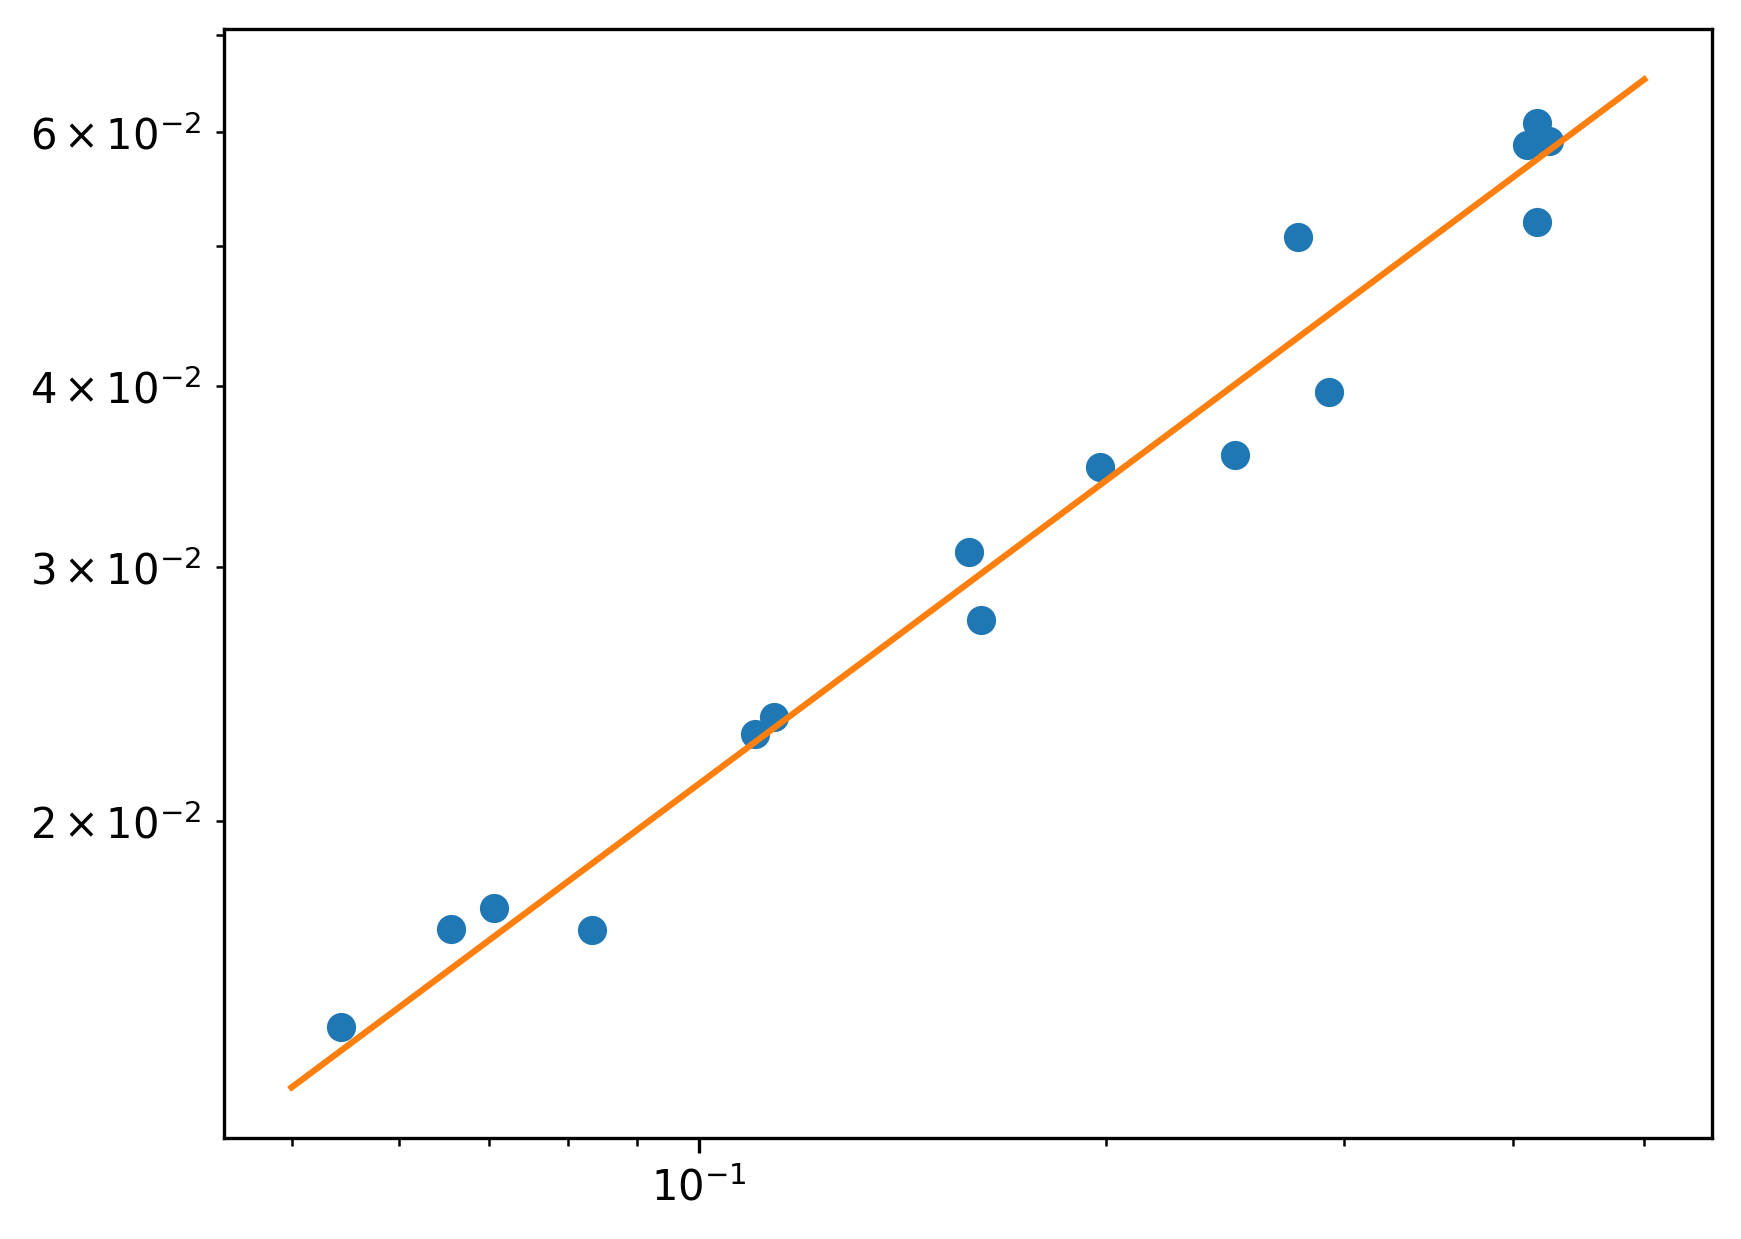

In [6]:
plt.loglog(data[:,0], data[:,1], 'o')
Go = np.geomspace(0.05, 0.5, endpoint=True)
rdot = res.x[0] * np.power(Go, res.x[1])
plt.loglog(Go, rdot)
plt.show()

## Design example

In [7]:
diameter_outer = Q_(1.175, 'in')

diameter_port = Q_(0.5, 'in')
diameter_throat = Q_(0.15, 'in')
length = Q_(10, 'in')
area_ratio = 5
density_fuel = Q_(915, 'kg/m^3')

vdot_ox = Q_(500, 'liter/min')
pressure_std = Q_(1, 'atm')
temperature_std = Q_(300, 'K')
gas_constant_air = Q_(8314, 'J/(kmol*K)') / Q_(32, 'kg/kmol')

In [8]:
# initial values
area_port = np.pi * diameter_port**2 / 4
area_burn = np.pi * diameter_port * length

mdot_ox = (pressure_std / (gas_constant_air * temperature_std)) * vdot_ox
print(f'Mass flow rate of oxidizer: {mdot_ox.to("kg/s"): .4f~P}')

Mass flow rate of oxidizer:  0.0108 kg/s


In [9]:
volume_fuel = np.pi * length * ((diameter_outer/2)**2 - (diameter_port/2)**2)
mass_fuel_initial = density_fuel * volume_fuel

print(f'Initial fuel mass: {mass_fuel_initial.to("kg"):.2f~P}')

Initial fuel mass: 0.13 kg


In [10]:
Gox = (mdot_ox / area_port).to('lb/(s*in^2)')
rdot = Q_(0.104 * Gox.magnitude**0.681, 'in/s')
print(f'Fuel burning rate: {rdot: .4f~P}')

Fuel burning rate:  0.0248 in/s


In [11]:
mdot_fuel = density_fuel * area_burn * rdot
print(f'Mass flow rate of fuel: {mdot_fuel.to("kg/s"): .4f~P}')

Mass flow rate of fuel:  0.0058 kg/s


In [12]:
ox_fuel_ratio = mdot_ox / mdot_fuel
print(f'O/F ratio: {ox_fuel_ratio.to_base_units(): .3f~P}')

O/F ratio:  1.857


In [13]:
cstar = Q_(1759, 'm/s')
gamma = 1.1728
MW = Q_(20.828, 'g/mol')

area_throat = np.pi * diameter_throat**2 / 4

pressure_chamber = cstar * (mdot_ox + mdot_fuel) / area_throat
print(f'Chamber pressure: {pressure_chamber.to("psi"):.1f~P}')

Chamber pressure: 373.0 psi


In [14]:
def calc_thrust_coeff(gamma, pressure_ratio):
    ''' Calculates thrust coefficient for optimum expansion.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return np.sqrt(
        2 * np.power(gamma, 2) / (gamma - 1) * 
        np.power(2 / (gamma + 1), (gamma + 1)/(gamma - 1)) * 
        (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
        )

def calc_area_ratio(gamma, pressure_ratio):
    '''Calculates area ratio based on specific heat ratio and pressure ratio.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return (
        np.power(2 / (gamma + 1), 1/(gamma-1)) * 
        np.power(pressure_ratio, 1 / gamma) *
        np.sqrt((gamma - 1) / (gamma + 1) /
                (1 - np.power(pressure_ratio, (1 - gamma)/gamma))
                )
        )

# This function returns zero for a given area ratio, pressure ratio, and gamma,
#and is used to numerically calculate pressure ratio given the other two values.
def root_area_ratio(pressure_ratio, gamma, area_ratio):
    ''' pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return area_ratio - calc_area_ratio(gamma, pressure_ratio)

In [15]:
sol = root_scalar(root_area_ratio, x0=20, x1=100, args=(gamma, area_ratio))
pressure_ratio = sol.root
print(f'Pressure ratio: {pressure_ratio:.2f}')

Pressure ratio: 29.57


In [16]:
thrust_coeff = calc_thrust_coeff(gamma, pressure_ratio)
print(f'Thrust coefficient: {thrust_coeff: .3f}')

specific_impulse = thrust_coeff * cstar / Q_(9.81, 'm/s^2')
thrust = thrust_coeff * pressure_chamber * area_throat

print(f'Specific impulse: {specific_impulse.to("s"): .1f~P}')
print(f'Thrust: {thrust.to("lbf"): .2f~P}')

Thrust coefficient:  1.485
Specific impulse:  266.3 s
Thrust:  9.79 lbf


In [17]:
oxid_fuel_ratios = np.arange(1.8, 5.3, 0.15)
gammas = []
cstars = []

with open('cea-output.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    if not line.strip():
        continue
    words = line.split()
    if words[0] == 'GAMMAs':
        gammas.append(float(words[2]))
    if words[0] == 'CSTAR,':
        cstars.append(float(words[2]))

gammas = np.array(gammas)
cstars = np.array(cstars)

assert len(oxid_fuel_ratios) == len(gammas)
assert len(oxid_fuel_ratios) == len(cstars)

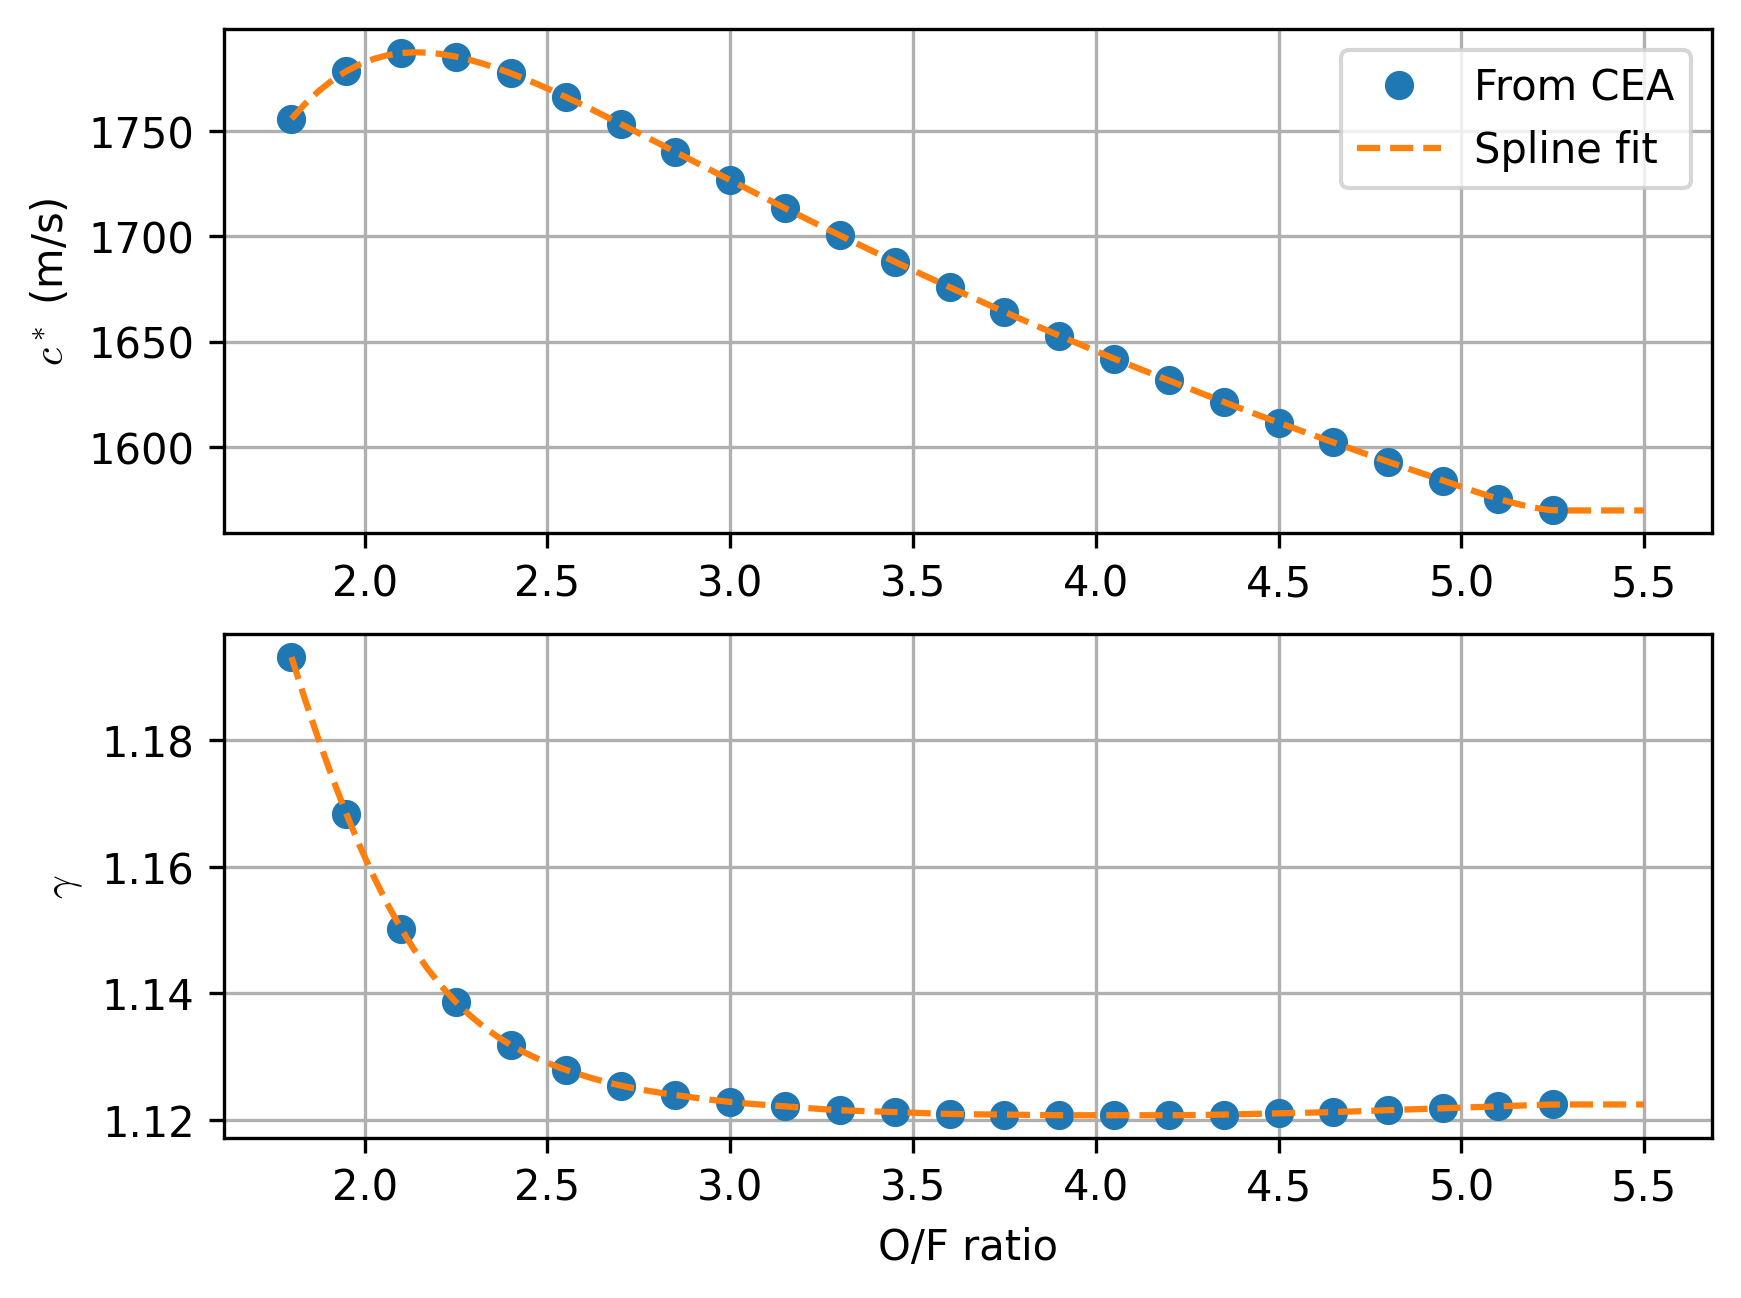

In [18]:
cstar_fit = UnivariateSpline(oxid_fuel_ratios, cstars, s=0, ext='const')
gamma_fit = UnivariateSpline(oxid_fuel_ratios, gammas, s=0, ext='const')

fig, axes = plt.subplots(2, 1)
x = np.linspace(1.8, 5.5, 100)

axes[0].plot(oxid_fuel_ratios, cstars, 'o', label='From CEA')
axes[0].plot(x, cstar_fit(x), '--', label='Spline fit')
axes[0].set_ylabel(r'$c^*$ (m/s)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(oxid_fuel_ratios, gammas, 'o')
axes[1].plot(x, gamma_fit(x), '--')
axes[1].set_ylabel(r'$\gamma$')
axes[1].set_xlabel('O/F ratio')
axes[1].grid(True)

plt.show()

In [19]:
delta_t = Q_(1.0, 's')
times = Q_(np.arange(0.0, 101.0, 1), 's')

radii = Q_(np.zeros_like(times), 'in')
mdot_fuels = Q_(np.zeros_like(times), 'kg/s')
mixture_ratios = np.zeros_like(times)
specific_impulses = Q_(np.zeros_like(times), 's')
thrusts = Q_(np.zeros_like(times), 'lbf')

radius_initial = diameter_port / 2

for idx, time in enumerate(times):
    radii[idx] = Q_((
        (2*0.681 + 1)*0.104 * (mdot_ox.to('lb/s').magnitude / np.pi)**0.681 * time.to('s').magnitude + 
        radius_initial.to('in').magnitude**(2*0.681 + 1)
        )**(1 / (2*0.681+1)),
        'in')
    
    area_port = np.pi * radii[idx]**2
    area_burn = np.pi * 2 * radii[idx] * length
    
    Gox = (mdot_ox / area_port).to('lb/(s*in^2)')
    rdot = Q_(0.104 * Gox.magnitude**0.681, 'in/s')
    mdot_fuels[idx] = density_fuel * area_burn * rdot
    mixture_ratios[idx] = mdot_ox / mdot_fuels[idx]
    
    cstar = Q_(cstar_fit(mixture_ratios[idx]), 'm/s')
    
    pressure_chamber = cstar * (mdot_ox + mdot_fuels[idx]) / area_throat
    
    specific_impulses[idx] = thrust_coeff * cstar / Q_(9.81, 'm/s^2')
    thrusts[idx] = thrust_coeff * pressure_chamber * area_throat
    
    # should stop when mass of fuel is exhausted
    mass_fuel_consumed = np.trapezoid(mdot_fuels, times)
    if mass_fuel_consumed >= mass_fuel_initial:
        idx_end = idx
        time_end = time
        print(f'Fuel exhausted at {time_end:.1f~P}')
        break

Fuel exhausted at 28.0 s


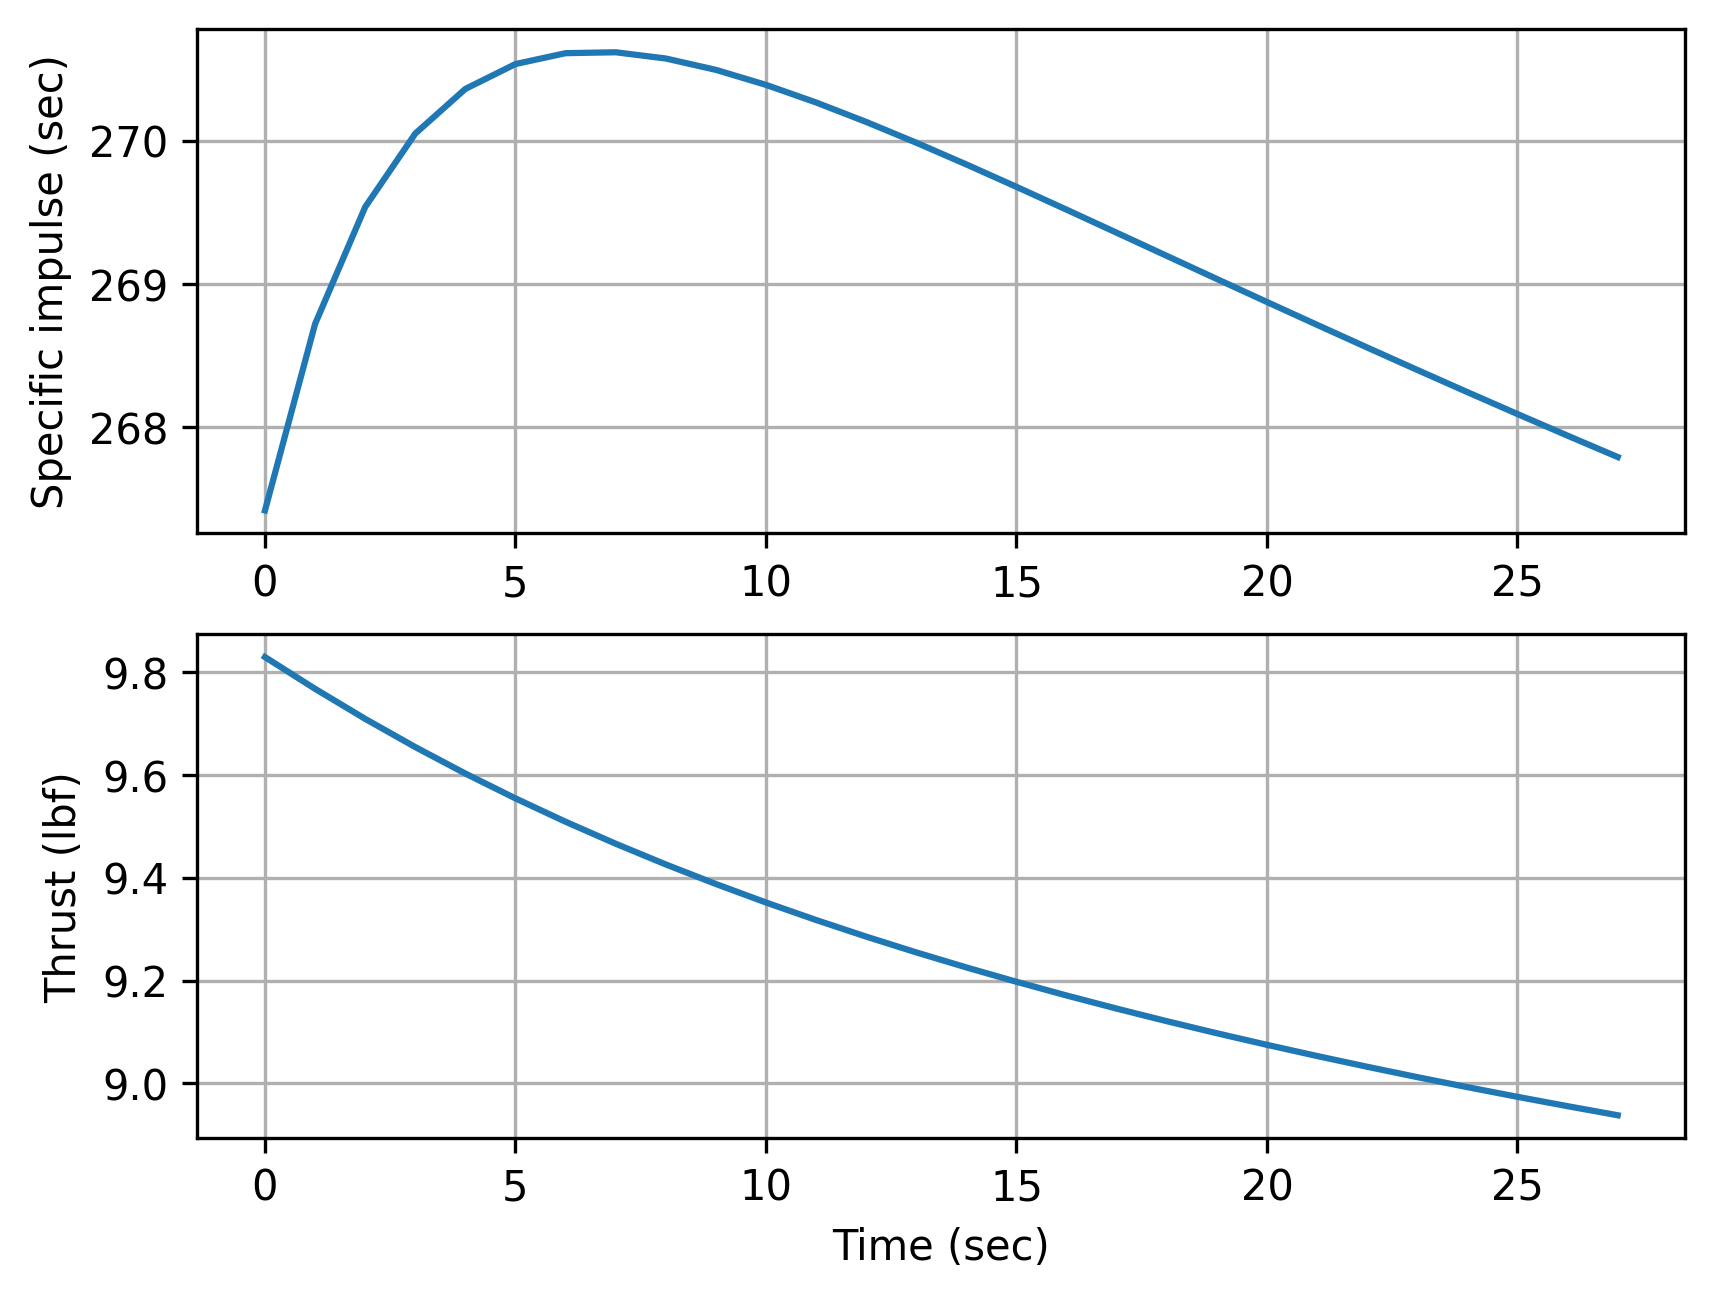

In [20]:
fig, axes = plt.subplots(2, 1)

axes[0].plot(times[:idx_end].magnitude, specific_impulses[:idx_end].to('s').magnitude)
axes[0].set_ylabel('Specific impulse (sec)')
axes[0].grid(True)

axes[1].plot(times[:idx_end].magnitude, thrusts[:idx_end].to('lbf').magnitude)
axes[1].set_ylabel('Thrust (lbf)')
axes[1].set_xlabel('Time (sec)')
axes[1].grid(True)

plt.show()